# Calculating Betas for the Market's Stocks #

### Calculating the Betas for all the Stocks in the Universe ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
from scipy.stats import norm
import statsmodels.api as sm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from other_data_functions import wexp
from regression_toolkit import add_constant
from regression_toolkit import rolling_wls_regression
from factors_toolkit import compute_factor_contributions
from factors_toolkit import compute_residual_returns

In [2]:
# Get the important data for the Risk-Free Rate
rfr = pd.read_csv(r"..\additional_data\risk_free_rate.csv")
rfr.set_index('Date', inplace=True)
rfr.index = pd.to_datetime(rfr.index)

# Get the important data for the S&P500
benchmark = pd.read_csv(r'..\additional_data\benchmark_returns.csv')
benchmark.set_index('Date', inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

In [3]:
# Import Data
returns = pd.read_csv(r'..\additional_data\stocks_returns.csv')
returns = returns.rename(columns={'Unnamed: 0':'Date'})
returns.set_index('Date', inplace=True)
returns.index = pd.to_datetime(returns.index)

returns

,A,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-05,NaN,NaN,NaN,0.048789,NaN,NaN,0.001281,-0.039193,NaN,-0.021506,...,0.002275,-0.008643,0.009709,0.018928,NaN,0.019293,NaN,0.016878,-0.003114,NaN
1999-01-06,NaN,NaN,NaN,-0.036742,NaN,NaN,-0.007712,0.000000,NaN,-0.036462,...,0.004535,0.039154,0.009615,0.019087,NaN,0.015170,NaN,0.002090,0.001039,NaN
1999-01-07,NaN,NaN,NaN,0.074963,NaN,NaN,-0.012987,-0.005831,NaN,0.020998,...,-0.004535,-0.001670,-0.002395,-0.004610,NaN,-0.005031,NaN,0.022705,-0.007295,NaN
1999-01-08,NaN,NaN,NaN,0.000000,NaN,NaN,-0.003929,-0.005865,NaN,0.014185,...,-0.006841,-0.005870,-0.012063,-0.004631,NaN,0.002519,NaN,0.104544,0.002090,NaN
1999-01-11,NaN,NaN,NaN,0.019256,NaN,NaN,-0.013211,-0.048202,NaN,0.003834,...,-0.023150,-0.042085,-0.032062,0.014337,NaN,0.026073,NaN,-0.045120,-0.027515,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011082,0.005780,-0.000457,0.011413,0.008985,0.003488,0.003929,0.006278,0.007940,0.002683,...,0.007210,0.000940,-0.002642,-0.023556,0.005432,0.008480,0.004484,0.012187,0.010791,0.002553
2024-12-26,-0.001986,0.000000,0.011595,0.003171,-0.004454,0.002442,0.004434,0.002802,-0.003324,0.004944,...,-0.000440,0.000845,0.013663,-0.006522,0.002705,0.007380,-0.000466,0.003559,0.006889,0.004966
2024-12-27,-0.002137,0.000000,-0.004077,-0.013331,-0.006663,-0.014403,-0.002432,-0.006369,-0.011862,-0.008208,...,-0.000587,-0.000094,-0.003163,-0.002183,-0.007966,-0.005678,-0.003549,-0.019799,-0.012179,-0.005574


In [4]:
# Define the tickers
tickers = returns.columns

In [5]:
# Set the arrays
y_matrix = returns.subtract(rfr['risk_free_rate'], axis=0)
x_matrix = benchmark['benchmark_returns'] - rfr['risk_free_rate']
x_matrix.name = 'market_premium'

# Add constant
x_matrix = add_constant(x_matrix)

x_matrix

,constant,market_premium
Date,,
1999-01-05,1,0.013359
1999-01-06,1,0.021768
1999-01-07,1,-0.002186
1999-01-08,1,0.004078
1999-01-11,1,-0.008966
...,...,...
2024-12-24,1,0.010855
2024-12-26,1,-0.000533
2024-12-27,1,-0.011246


In [15]:
# Let us get the betas of each stock
coefficients = rolling_wls_regression(
    y_matrix,
    x_matrix
)

coefficients

{'alphas':                    A       AAL       AAP      AAPL      ABBV      ABNB  \
 Date                                                                     
 2000-01-03       NaN       NaN       NaN  0.004124       NaN       NaN   
 2000-01-04       NaN       NaN       NaN  0.003760       NaN       NaN   
 2000-01-05       NaN       NaN       NaN  0.003944       NaN       NaN   
 2000-01-06       NaN       NaN       NaN  0.003109       NaN       NaN   
 2000-01-07       NaN       NaN       NaN  0.003157       NaN       NaN   
 ...              ...       ...       ...       ...       ...       ...   
 2024-12-24 -0.000806  0.000867 -0.002450  0.000759  0.000141 -0.001374   
 2024-12-26 -0.000812  0.000900 -0.002330  0.000793  0.000112 -0.001308   
 2024-12-27 -0.000753  0.001030 -0.002273  0.000762  0.000073 -0.001267   
 2024-12-30 -0.000749  0.001260 -0.001812  0.000724  0.000010 -0.001247   
 2024-12-31 -0.000708  0.001236 -0.001560  0.000701  0.000078 -0.001215   
 
             

In [16]:
# Create Alpha's DataFrame
alpha_df = coefficients['alphas']

alpha_df

,A,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,0.004124,NaN,NaN,-0.002341,-0.002562,NaN,0.002861,...,-0.001725,-0.000200,-0.000833,-0.004972,NaN,-0.002135,NaN,0.002072,-0.001188,NaN
2000-01-04,NaN,NaN,NaN,0.003760,NaN,NaN,-0.002196,-0.002559,NaN,0.002539,...,-0.001422,-0.000160,-0.000660,-0.005076,NaN,-0.002140,NaN,0.002164,-0.001284,NaN
2000-01-05,NaN,NaN,NaN,0.003944,NaN,NaN,-0.002158,-0.001900,NaN,0.002760,...,-0.001140,0.000172,-0.000536,-0.004695,NaN,-0.002105,NaN,0.002304,-0.001266,NaN
2000-01-06,NaN,NaN,NaN,0.003109,NaN,NaN,-0.001882,-0.001953,NaN,0.002753,...,-0.001197,0.000536,-0.000525,-0.004822,NaN,-0.002153,NaN,0.001835,-0.001152,NaN
2000-01-07,NaN,NaN,NaN,0.003157,NaN,NaN,-0.001976,-0.001558,NaN,0.002828,...,-0.001226,0.000434,-0.000606,-0.004779,NaN,-0.002387,NaN,0.001439,-0.001288,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.000806,0.000867,-0.002450,0.000759,0.000141,-0.001374,0.000066,-0.000144,-0.000202,-0.002482,...,0.000844,-0.000473,-0.003213,-0.003158,-0.001282,-0.000326,-0.000896,0.000478,0.000056,-0.001266
2024-12-26,-0.000812,0.000900,-0.002330,0.000793,0.000112,-0.001308,0.000096,-0.000109,-0.000214,-0.002416,...,0.000829,-0.000467,-0.003104,-0.003188,-0.001259,-0.000268,-0.000907,0.000475,0.000087,-0.001222
2024-12-27,-0.000753,0.001030,-0.002273,0.000762,0.000073,-0.001267,0.000080,-0.000112,-0.000252,-0.002341,...,0.000820,-0.000438,-0.003064,-0.003103,-0.001236,-0.000279,-0.000885,0.000424,0.000133,-0.001225


In [17]:
# Create Beta's DataFrame
betas_df = coefficients['betas']

betas_df

,A,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,1.335080,NaN,NaN,1.084290,-0.114335,NaN,1.052979,...,0.348611,0.530261,0.557190,0.828263,NaN,0.530965,NaN,0.748833,0.852891,NaN
2000-01-04,NaN,NaN,NaN,1.418454,NaN,NaN,1.051470,-0.091197,NaN,1.168953,...,0.264786,0.529788,0.506847,0.848708,NaN,0.522835,NaN,0.720079,0.888770,NaN
2000-01-05,NaN,NaN,NaN,1.440879,NaN,NaN,1.060008,-0.084862,NaN,1.189834,...,0.268014,0.525762,0.508524,0.851524,NaN,0.521590,NaN,0.726198,0.893849,NaN
2000-01-06,NaN,NaN,NaN,1.440651,NaN,NaN,1.060747,-0.085251,NaN,1.190678,...,0.267661,0.527185,0.508530,0.851091,NaN,0.521318,NaN,0.725240,0.894127,NaN
2000-01-07,NaN,NaN,NaN,1.447918,NaN,NaN,1.038326,-0.001634,NaN,1.208871,...,0.259260,0.502271,0.486571,0.859092,NaN,0.471773,NaN,0.673694,0.864814,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.756693,1.269029,1.006397,0.900453,0.214614,1.303138,0.153382,0.532669,0.639139,1.276747,...,-0.038703,0.198814,0.542305,1.006918,0.985409,0.457147,0.436171,1.235720,1.404490,0.510449
2024-12-26,0.756891,1.270957,1.004937,0.900734,0.215589,1.304253,0.152650,0.532828,0.640070,1.275916,...,-0.038702,0.198456,0.538876,1.006911,0.984227,0.455964,0.435341,1.233641,1.402107,0.509350
2024-12-27,0.747591,1.253666,0.992316,0.906195,0.221473,1.302630,0.153808,0.533355,0.646099,1.264858,...,-0.036025,0.195271,0.531051,0.990680,0.978535,0.456436,0.432578,1.242268,1.397838,0.507575


In [18]:
# Create the Sigma's DataFrame
sigma_df = coefficients['sigmas']

sigma_df

,A,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,0.033902,NaN,NaN,0.018910,0.035973,NaN,0.028310,...,0.012660,0.016277,0.020118,0.035136,NaN,0.026228,NaN,0.029544,0.021377,NaN
2000-01-04,NaN,NaN,NaN,0.033937,NaN,NaN,0.018916,0.035913,NaN,0.028400,...,0.012891,0.016247,0.020173,0.035123,NaN,0.026220,NaN,0.029553,0.021405,NaN
2000-01-05,NaN,NaN,NaN,0.033645,NaN,NaN,0.018828,0.036373,NaN,0.028121,...,0.013116,0.016481,0.020200,0.035277,NaN,0.026221,NaN,0.029551,0.021381,NaN
2000-01-06,NaN,NaN,NaN,0.033840,NaN,NaN,0.018949,0.036375,NaN,0.028093,...,0.013126,0.016776,0.020200,0.035295,NaN,0.026225,NaN,0.029748,0.021397,NaN
2000-01-07,NaN,NaN,NaN,0.033837,NaN,NaN,0.018972,0.036584,NaN,0.028109,...,0.013129,0.016793,0.020213,0.035290,NaN,0.026351,NaN,0.029146,0.021415,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.015074,0.025509,0.028180,0.012005,0.015157,0.018435,0.011140,0.013932,0.014680,0.021193,...,0.013830,0.012035,0.026660,0.028608,0.011024,0.009482,0.012993,0.016103,0.020150,0.015017
2024-12-26,0.015074,0.025480,0.028190,0.011998,0.015158,0.018398,0.011143,0.013925,0.014677,0.021197,...,0.013829,0.012035,0.026675,0.028607,0.011022,0.009494,0.012983,0.016070,0.020135,0.015022
2024-12-27,0.015084,0.025493,0.028186,0.011999,0.015161,0.018370,0.011139,0.013925,0.014678,0.021202,...,0.013828,0.012031,0.026676,0.028613,0.011019,0.009491,0.012983,0.016073,0.020125,0.015016


In [19]:
# Save the betas
#alpha_df.to_csv(r"..\additional_data\capm_ralpha.csv")
#betas_df.to_csv(r"..\additional_data\capm_rbetas.csv")
#sigma_df.to_csv(r"..\additional_data\capm_rsigma.csv")

In [6]:
# We can use StatsModels efficiently to get the betas for the whole history
betas_list = []

# Loop to Obtain Betas and Alpha + Residuals
for ticker in tickers:
    # Define series
    y_series = y_matrix[ticker].dropna()
    
    # Set the Window
    window = len(y_series)
    weights = window * wexp(window, window/2)
    
    # Define weights
    model = sm.WLS(y_series, x_matrix.loc[y_series.index], weights=weights)
    results = model.fit()
    
    beta = results.params.iloc[1]
    
    betas_list.append(beta)

# Create Beta Series
betas_series = pd.Series(betas_list, index=tickers)
betas_series.name = 'history_beta'

betas_series

A       1.161226
AAL     1.512582
AAP     0.849244
AAPL    1.138451
ABBV    0.636792
          ...   
YUM     0.787745
ZBH     0.810686
ZBRA    1.122544
ZION    1.318172
ZTS     0.917258
Name: history_beta, Length: 611, dtype: float64

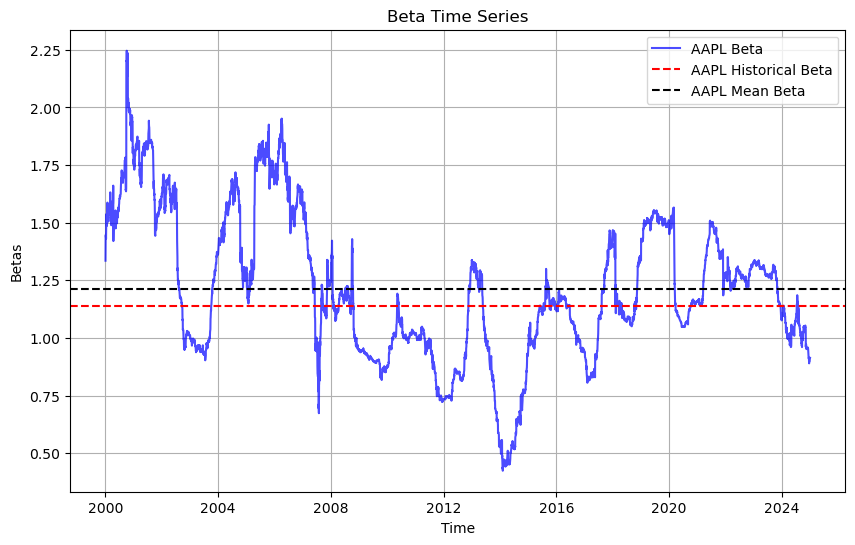

In [21]:
# Plot
ticker = 'AAPL'

# Mean
mean = betas_df[ticker].mean()

# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_df[ticker], label=f'{ticker} Beta', color='blue', alpha=0.7)
plt.axhline(y=betas_series.loc[ticker], color='red', linestyle='dashed', label=f'{ticker} Historical Beta')
plt.axhline(y=mean, color='black', linestyle='dashed', label=f'{ticker} Mean Beta')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.grid()
plt.show()

### Beta Analytics ###

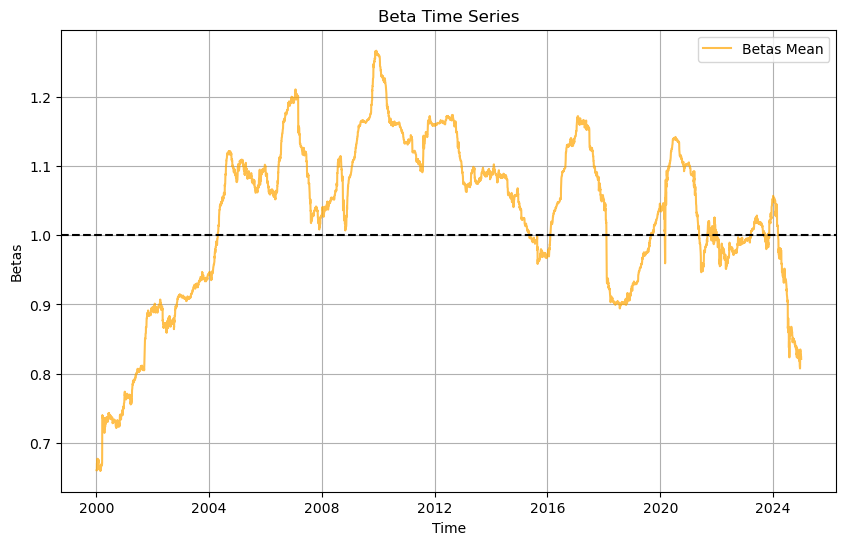

In [22]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_df.mean(axis=1), label='Betas Mean', color='orange', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.grid()
plt.show()

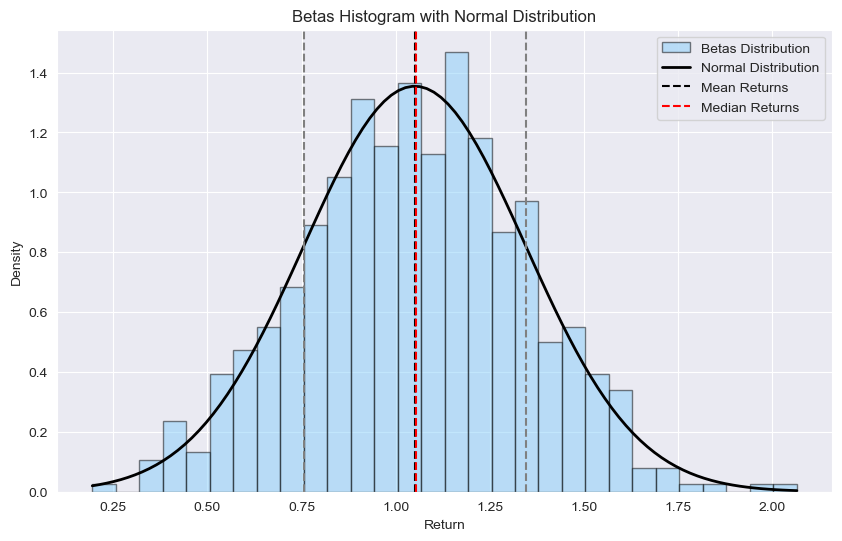

In [8]:
# Calculate Mean and Standard Deviation
mu = betas_series.mean()
sigma = betas_series.std()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(betas_series, bins=30, density=True, color='lightskyblue', alpha=0.5, edgecolor='black', label='Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(betas_series.min(), betas_series.max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=betas_series.median(), color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

### Comparing Residuals ###

In [24]:
# Compute Residuals in the Alternative Way
stock = 'JPM'

# Cut DataFrames
stock_beta = betas_df[stock].dropna()
r_i = y_matrix[stock].loc[stock_beta.index]
r_m = x_matrix['market_premium'].loc[stock_beta.index]

In [25]:
# Calculate factor returns
r_f = compute_factor_contributions(r_m, stock_beta)

# Calculate residual returns
residual_returns = compute_residual_returns(r_i, r_m, stock_beta)
residual_returns.name = 'residual_returns'

residual_returns

Date
2000-01-03   -0.049362
2000-01-04    0.033716
2000-01-05   -0.008859
2000-01-06    0.012808
2000-01-07   -0.019301
                ...   
2024-12-24    0.006487
2024-12-26    0.003768
2024-12-27    0.001758
2024-12-30    0.001859
2024-12-31    0.005424
Name: residual_returns, Length: 6289, dtype: float64

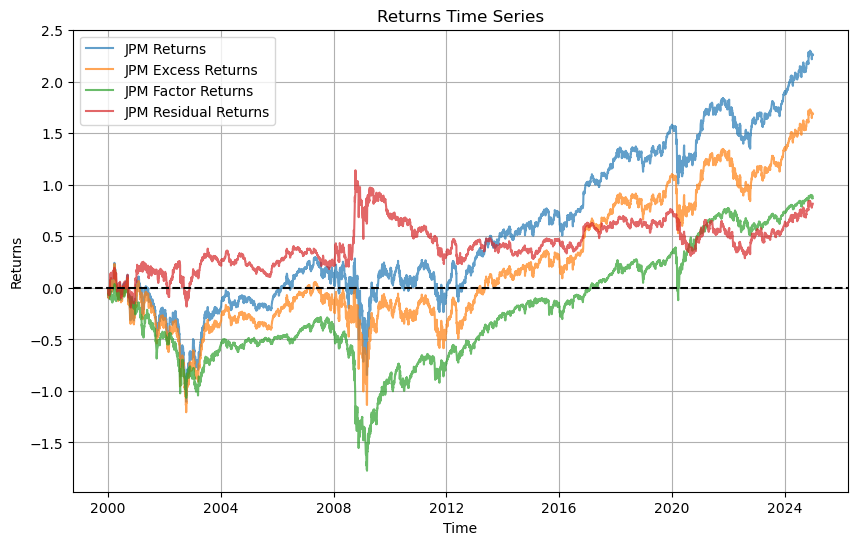

In [26]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(returns[stock].loc['2000':].cumsum(), label=f'{stock} Returns', alpha=0.7)
#plt.plot(benchmark.loc['2000':].cumsum(), label='Benchmark Returns', alpha=0.7)
plt.plot(r_i.cumsum(), label=f'{stock} Excess Returns', alpha=0.7)
plt.plot(r_f.cumsum(), label=f'{stock} Factor Returns', alpha=0.7)
plt.plot(residual_returns.cumsum(), label=f'{stock} Residual Returns', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid()
plt.show()

The method using the rolling betas adds so much noise to the calculation of the residual returns, especially because sometimes the alpha coefficient has a bias. So we prefer to use the residuals of the whole time stamp regression.

In [27]:
# Calculate the Residual Returns for every stock
residual_returns_dict = {}

# Create the Loop to Obtain the Betas
for ticker in tickers:
    
    index = betas_df[ticker].dropna().index
    
    df = compute_residual_returns(
        y_matrix[ticker].loc[index], 
        x_matrix['market_premium'].loc[index],
        betas_df[ticker].loc[index]
    )
    
    residual_returns_dict[ticker] = df

# Create the DataFrame
df_residual_returns = pd.DataFrame.from_dict(residual_returns_dict)

In [28]:
df_residual_returns

,A,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,0.097904,NaN,NaN,-0.026394,-0.094632,NaN,-0.015300,...,-0.022749,-0.023323,-0.000039,0.071938,NaN,-0.029562,NaN,-0.030971,-0.056171,NaN
2000-01-04,NaN,NaN,NaN,-0.032542,NaN,NaN,0.012133,-0.009212,NaN,-0.041883,...,0.032985,0.001290,0.019728,-0.014472,NaN,0.000052,NaN,0.013571,-0.014905,NaN
2000-01-05,NaN,NaN,NaN,0.011841,NaN,NaN,-0.003864,0.088796,NaN,0.017328,...,0.037211,0.051986,0.016073,0.048546,NaN,0.004025,NaN,0.017518,-0.002920,NaN
2000-01-06,NaN,NaN,NaN,-0.091810,NaN,NaN,0.033390,-0.010166,NaN,0.007027,...,-0.009720,0.049815,0.000731,-0.021674,NaN,-0.009124,NaN,-0.056407,0.013244,NaN
2000-01-07,NaN,NaN,NaN,0.007659,NaN,NaN,-0.017128,0.053930,NaN,0.015164,...,-0.007064,-0.016455,-0.015713,0.000419,NaN,-0.035257,NaN,-0.029227,-0.020807,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.002741,-0.008122,-0.011509,0.001511,0.006528,-0.010785,0.002137,0.000369,0.000875,-0.011304,...,0.007502,-0.001345,-0.008656,-0.034613,-0.005392,0.003391,-0.000378,-0.001354,-0.004582,-0.003115
2024-12-26,-0.001710,0.000550,0.012003,0.003524,-0.004467,0.003010,0.004388,0.002959,-0.003110,0.005497,...,-0.000588,0.000824,0.013823,-0.006112,0.003102,0.007496,-0.000361,0.004090,0.007509,0.005111
2024-12-27,0.006141,0.013970,0.006954,-0.003268,-0.004300,0.000118,-0.000831,-0.000500,-0.004724,0.005887,...,-0.001120,0.001974,0.002681,0.008829,0.002910,-0.000673,0.001187,-0.005957,0.003413,0.000006


In [29]:
# Save the data
betas_series.to_csv(r"..\additional_data\capm_hbetas.csv")
df_residual_returns.to_csv(r"..\additional_data\capm_residual_returns.csv")